# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

## What I'm Doing
- [x] Remove conditioning fantasized surrogate on gradient samples
- [ ] Write a method for estimating the acquisition function using forward mode differentation

We have a few ways of computing surrogate perturbations. One relies on computing perturbations of our `RBFsurrogate` with the data and spatial perturbations performed jointly. One relies on `FantasySurrogate` which leverages smart indexing to compute perturbations of data and spatial locations independently. The final one is wrt to `SmartFantasyRBFsurrogate` which does them idenpendtly as well.

## Possible Issues
- [ ] Low discrepancy seqeuence possibly
- [ ] Adjoint differentiation seems to be off. I think we need to check our hessians and return 0 if the det is too small.
- [ ] Use the Forward and Adjoint API to rollout trajectories at some fixed point to identify why they are different for the stochastic case.
- [ ] Consider reusing the same trajectory object inplace to avoid allocations.

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Roots
using Profile
using ProfileView

All the necessary imports for our computations of interest

In [2]:
include("../rollout_bayesian_optimization.jl")

deterministic_solve (generic function with 1 method)

## Basic Setup

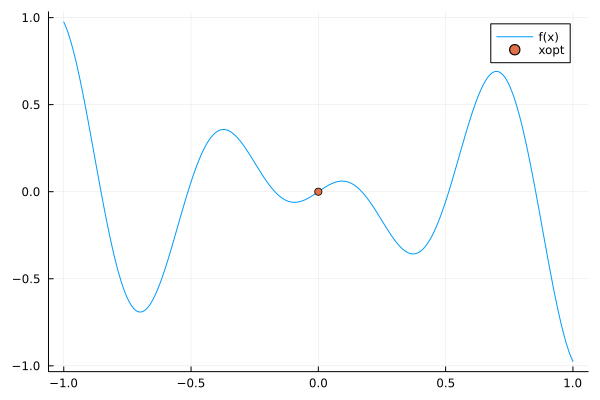

In [3]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 9.2, lb=-1, ub=1.)
# testfn = TestConstant(lbs=[0.], ubs=[1.])
# testfn = TestQuadratic1D()
tplot(testfn)

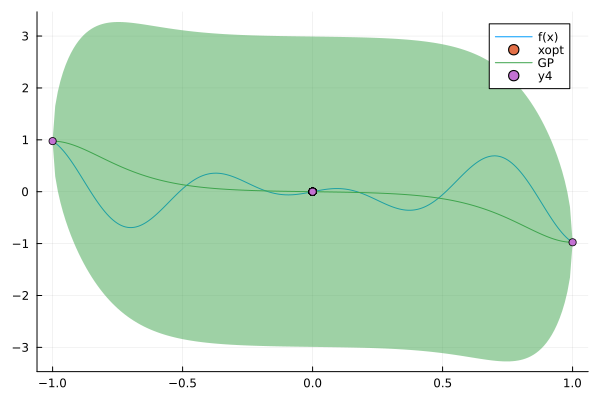

In [14]:
MC_SAMPLES = 5
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = false
INITIAL_SAMPLES = 2

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-8
θinit = [0.0]
ψ = kernel_scale(Matern52, [5., .25])

lbs, ubs = get_bounds(testfn)
midpoint = (ubs + lbs) / 2
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=midpoint,
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hypers=θinit
)
es = ExperimentSetup(number_of_starts=NUMBER_OF_STARTS, tp=tp)

# Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
Xinit = [-1.;; 1.;;]
yinit = testfn(Xinit)
sur = Surrogate(ψ, Xinit, yinit, decision_rule=EI(), σn2=σn2);
osur = fit_surrogate(ψ, Xinit, yinit, σn2=σn2);

tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
scatter!(sur.X', sur.y)

## Visualizing Base Policy Solves along a Trajectory

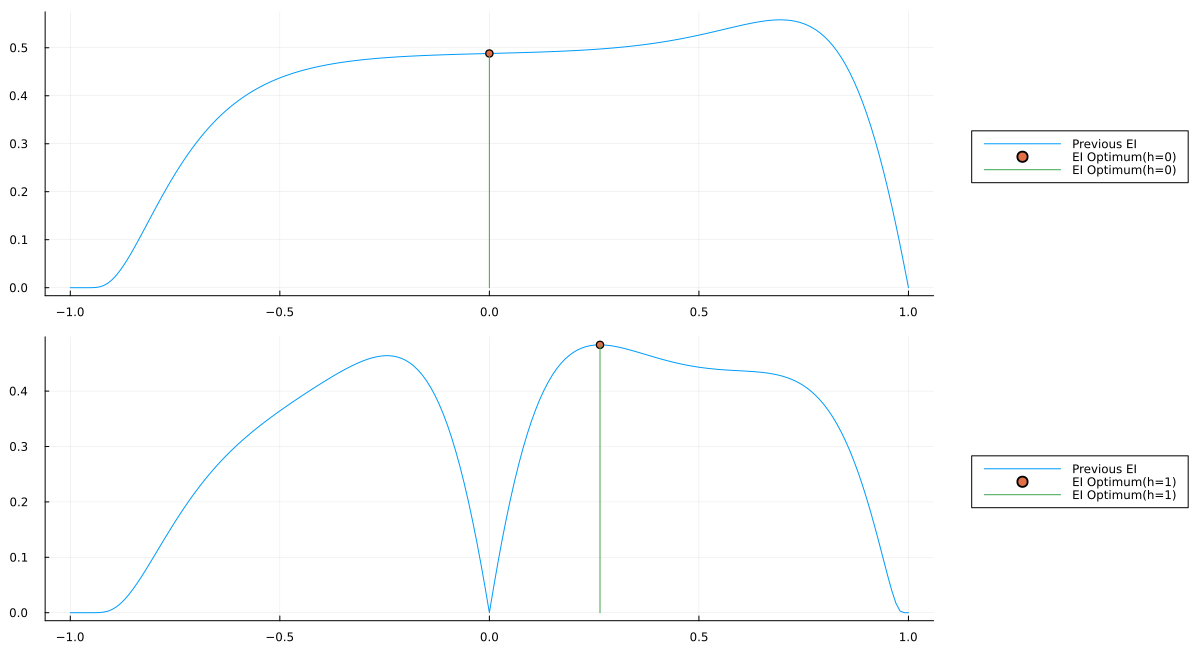

In [15]:
IS_DETERMINISTIC = false
# Construct trajectory
AT = AdjointTrajectory(
    sur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(AT),
    stdnormal=get_samples_rnstream(tp, sample_index=1),
    max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f,
    gradient=testfn.∇f,
    max_invocations=get_horizon(tp) + 1
)
attach_observable!(AT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)
# Adjoint Rollout
rollout!(
    AT,
    lowerbounds=lbs,
    upperbounds=ubs,
    xstarts=get_starts(es),
    get_observation=get_observable(AT)
)

all_plots = []

for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = eval(AT.fs([xx], θinit, fantasy_index=upto_index-1))
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    
    scatter!(
        [target_location],
        [eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    
    plot!(
        [target_location, target_location],
        [0., eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [17]:
etos = []
forward_etos = []
fd_etos = []
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)
h = 1e-6

for (index, xx) in enumerate(domain)
    print("|")
    # Adjoint
    set_starting_point!(tp, [xx])
    eto = simulate_adjoint_trajectory(
        sur,
        tp,
        inner_solve_xstarts=get_starts(es),
        resolutions=get_container(es, symbol=:f),
        spatial_gradients_container=get_container(es, symbol=:grad_f),
        hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    )
    push!(etos, eto)

    # # Finite Difference
    # set_starting_point!(tp, [xx + h])
    # etop = simulate_adjoint_trajectory(
    #     sur,
    #     tp,
    #     inner_solve_xstarts=get_starts(es),
    #     resolutions=get_container(es, symbol=:f),
    #     spatial_gradients_container=get_container(es, symbol=:grad_f),
    #     hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    # )
    # set_starting_point!(tp, [xx - h])
    # etom = simulate_adjoint_trajectory(
    #     sur,
    #     tp,
    #     inner_solve_xstarts=get_starts(es),
    #     resolutions=get_container(es, symbol=:f),
    #     spatial_gradients_container=get_container(es, symbol=:grad_f),
    #     hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
    # )
    # push!(fd_etos, (etop, etom))

    # # Forward Trajectory
    # set_starting_point!(tp, [xx])
    # eto = simulate_trajectory(
    #     osur,
    #     tp,
    #     xstarts=get_starts(es),
    #     resolutions=get_container(es, symbol=:f),
    #     gradient_resolutions=get_container(es, symbol=:grad_f)
    # )
    # push!(forward_etos, eto)
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Gtk4.GtkWindowLeaf(accessible-role=GTK_ACCESSIBLE_ROLE_APPLICATION, name="", parent, root, width-request=-1, height-request=-1, visible=true, sensitive=true, can-focus=true, has-focus=false, can-target=true, focus-on-click=true, focusable=false, has-default=false, receives-default=false, cursor, has-tooltip=false, tooltip-markup=nothing, tooltip-text=nothing, opacity=1.000000, overflow=GTK_OVERFLOW_HIDDEN, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, hexpand=false, vexpand=false, hexpand-set=false, vexpand-set=false, scale-factor=2, css-name="window", css-classes, layout-manager, title="Profile", resizable=true, modal=false, default-width=800, default-height=600, destroy-with-parent=false, hide-on-close=false, icon-name=nothing, display, decorated=true, deletable=true, transient-for, application, default-widget, focus-widget, child, titlebar, handle-menubar-accel=true, is-active=false, suspended=false, startup-id, mnemonics-

/Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout.jl:662, MethodInstance for var"#simulate_adjoint_trajectory#620"(::Matrix{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::typeof(simulate_adjoint_trajectory), ::Surrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}, ::TrajectoryParameters)
/Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout.jl:662, MethodInstance for var"#simulate_adjoint_trajectory#620"(::Matrix{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Matrix{Float64}, ::typeof(simulate_adjoint_trajectory), ::Surrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}, ::TrajectoryParameters)


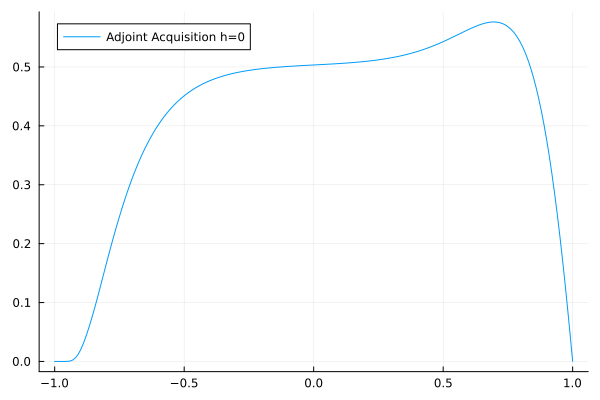

In [38]:
plot(
    domain,
    [mean(eto) for eto in etos],
    # ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [eto[1] for eto in forward_etos],
#     # ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
#     label="Forward Acquisition h=$(get_horizon(tp))"
# )

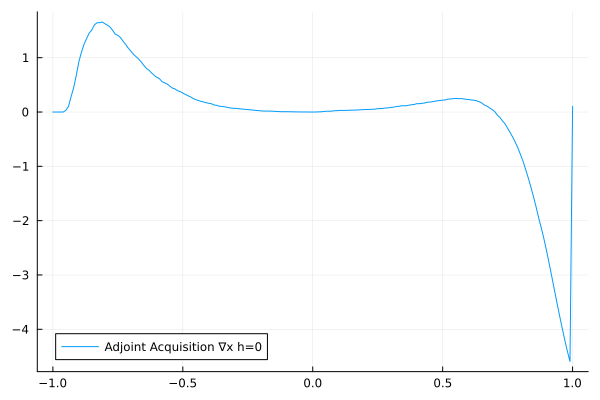

In [39]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [eto[2] for eto in forward_etos],
#     # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
#     label="Forward Acquisition ∇x h=$(get_horizon(tp))"
# )

# tpe, tme = similar(domain), similar(domain)
# for (i, (etop, etom)) in enumerate(fd_etos)
#     tpe[i] = mean(etop)
#     tme[i] = mean(etom)
# end

# plot!(
#     domain,
#     (tpe - tme) ./ 2h,
#     # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
#     label="Finite Difference"
# )

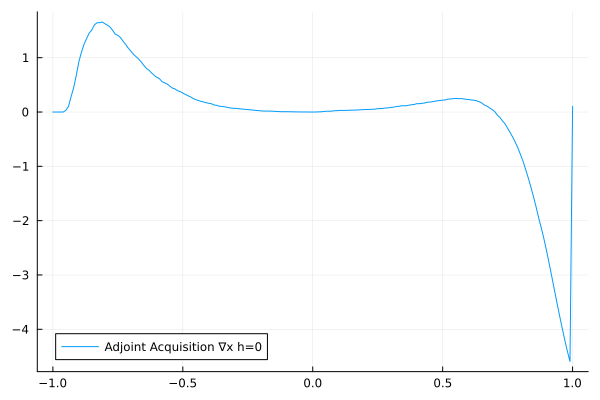

In [83]:
plot(
    domain,
    [first(gradient(eto, )) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)

In [7]:
fsur = FantasySurrogate(sur, HORIZON)

FantasySurrogate{RBF = RadialBasisFunction, P = DecisionRule{EI}}

In [9]:
output = @timed begin
    for _ in 1:100
        simulate_adjoint_trajectory(
            sur,
            tp,
            inner_solve_xstarts=get_starts(es),
            resolutions=get_container(es, symbol=:f),
            spatial_gradients_container=get_container(es, symbol=:grad_f),
            hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
        )
    end
end
to(output.bytes, key="MB")

"57.51800537109375MB"

In [19]:
@code_warntype simulate_adjoint_trajectory(
    sur,
    fsur,
    tp,
    inner_solve_xstarts=get_starts(es),
    resolutions=get_container(es, symbol=:f),
    spatial_gradients_container=get_container(es, symbol=:grad_f),
    hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
)

MethodInstance for Core.kwcall(::@NamedTuple{inner_solve_xstarts::Matrix{Float64}, resolutions::Vector{Float64}, spatial_gradients_container::Matrix{Float64}, hyperparameter_gradients_container::Matrix{Float64}}, ::typeof(simulate_adjoint_trajectory), ::Surrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}, ::FantasySurrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}, ::TrajectoryParameters)
  from kwcall(::NamedTuple, ::typeof(simulate_adjoint_trajectory), s::Surrogate, fs::FantasySurrogate, tp::TrajectoryParameters) @ Main ~/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout.jl:695
Arguments
  _::Core.Const(Core.kwcall)
  @_2::@NamedTuple{inner_solve_xstarts::Matrix{Float64}, resolutions::Vector{Float64}, spatial_gradients_container::Matrix{Float64}, hyperparameter_gradients_container::Matrix{Float64}}
  @_3::Core.Const(simulate_adjoint_trajectory)
  s::Surrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{

In [79]:
output = @timed AdjointTrajectory(sur, start=[0.], hypers=[0.], horizon=HORIZON)
to(output.bytes, key="KB")

"1.8125KB"

In [80]:
output = @timed AdjointTrajectory(sur, fsur, start=[0.], hypers=[0.], horizon=HORIZON)
to(output.bytes, key="KB")

"0.25KB"

In [13]:
# output = @timed begin
    # Construct trajectory
    AT = AdjointTrajectory(
        sur,
        start=get_starting_point(tp),
        hypers=get_hyperparameters(tp),
        horizon=get_horizon(tp)
    )
    
    stochastic_sampler = StochasticObservable(
        surrogate=get_fantasy_surrogate(AT),
        stdnormal=get_samples_rnstream(tp, sample_index=1),
        max_invocations=get_horizon(tp) + 1
    )
    attach_observable!(AT, stochastic_sampler)
    # Adjoint Rollout
    @code_warntype rollout!(
        AT,
        lowerbounds=lbs,
        upperbounds=ubs,
        xstarts=get_starts(es),
        get_observation=get_observable(AT)
    )
    reset!(get_fantasy_surrogate(AT))
# end
# to(output.bytes, key="MB")

MethodInstance for Core.kwcall(::@NamedTuple{lowerbounds::Vector{Float64}, upperbounds::Vector{Float64}, xstarts::Matrix{Float64}, get_observation::StochasticObservable{FantasySurrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}}}, ::typeof(rollout!), ::AdjointTrajectory)
  from kwcall(::NamedTuple, ::typeof(rollout!), T::AdjointTrajectory) @ Main ~/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout.jl:194
Arguments
  _::Core.Const(Core.kwcall)
  @_2::@NamedTuple{lowerbounds::Vector{Float64}, upperbounds::Vector{Float64}, xstarts::Matrix{Float64}, get_observation::StochasticObservable{FantasySurrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}}}
  @_3::Core.Const(rollout!)
  T::AdjointTrajectory
Locals
  @_5::Union{StochasticObservable{FantasySurrogate{RadialBasisFunction, DecisionRule{var"#ei#170"{Float64}}}}, VecOrMat{Float64}}
  lowerbounds::Vector{Float64}
  upperbounds::Vector{Float64}
  get_observation::St

1-element Vector{Vector{Float64}}:
 [0.1949691406688574, -0.1949691406688574]

In [104]:
output.bytes * MC_SAMPLES

697600